<a href="https://colab.research.google.com/github/depctg/udacity-cs344-colab/blob/master/notebook/udacity_cs344_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Homework 2 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/Guoning-Chen/cgn-cs344-colab.git
!pip install git+http://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "cgn-cs344-colab/src/HW2"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir cgn-cs344-colab/build
%cd cgn-cs344-colab/build
!cmake ../src

Cloning into 'cgn-cs344-colab'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 219 (delta 60), reused 71 (delta 44), pack-reused 120
Receiving objects: 100% (219/219), 4.84 MiB | 6.68 MiB/s, done.
Resolving deltas: 100% (89/89), done.
  Cloning http://github.com/depctg/nvcc4jupyter.git to /tmp/pip-req-build-m2bk44he
  Running command git clone --filter=blob:none --quiet http://github.com/depctg/nvcc4jupyter.git /tmp/pip-req-build-m2bk44he
  Resolved http://github.com/depctg/nvcc4jupyter.git to commit 63b811d987446c2a3783845b7b85cda6e562b71a
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4316 sha256=f15795eda0deeca455fcc1c72c9e92b31b3475a18337937ec56f7c690c4607e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-0yjmj1ag/wheels/1c/36/ad/93d64780b30be401df70e5a84a1517cfc016a4bb0520854d1e
Successfully built NVCCPl

In [40]:
%%cuda --name student_func.cu

// Homework 2
// Image Blurring
//
// In this homework we are blurring an image. To do this, imagine that we have
// a square array of weight values. For each pixel in the image, imagine that we
// overlay this square array of weights on top of the image such that the center
// of the weight array is aligned with the current pixel. To compute a blurred
// pixel value, we multiply each pair of numbers that line up. In other words, we
// multiply each weight with the pixel underneath it. Finally, we add up all of the
// multiplied numbers and assign that value to our output for the current pixel.
// We repeat this process for all the pixels in the image.

// To help get you started, we have included some useful notes here.

//****************************************************************************

// For a color image that has multiple channels, we suggest separating
// the different color channels so that each color is stored contiguously
// instead of being interleaved. This will simplify your code.

// That is instead of RGBARGBARGBARGBA... we suggest transforming to three
// arrays (as in the previous homework we ignore the alpha channel again):
//  1) RRRRRRRR...
//  2) GGGGGGGG...
//  3) BBBBBBBB...
//
// The original layout is known an Array of Structures (AoS) whereas the
// format we are converting to is known as a Structure of Arrays (SoA).

// As a warm-up, we will ask you to write the kernel that performs this
// separation. You should then write the "meat" of the assignment,
// which is the kernel that performs the actual blur. We provide code that
// re-combines your blurred results for each color channel.

//****************************************************************************

// You must fill in the gaussian_blur kernel to perform the blurring of the
// inputChannel, using the array of weights, and put the result in the outputChannel.

// Here is an example of computing a blur, using a weighted average, for a single
// pixel in a small image.
//
// Array of weights:
//
//  0.0  0.2  0.0
//  0.2  0.2  0.2
//  0.0  0.2  0.0
//
// Image (note that we align the array of weights to the center of the box):
//
//    1  2  5  2  0  3
//       -------
//    3 |2  5  1| 6  0       0.0*2 + 0.2*5 + 0.0*1 +
//      |       |
//    4 |3  6  2| 1  4   ->  0.2*3 + 0.2*6 + 0.2*2 +   ->  3.2
//      |       |
//    0 |4  0  3| 4  2       0.0*4 + 0.2*0 + 0.0*3
//       -------
//    9  6  5  0  3  9
//
//         (1)                         (2)                 (3)
//
// A good starting place is to map each thread to a pixel as you have before.
// Then every thread can perform steps 2 and 3 in the diagram above
// completely independently of one another.

// Note that the array of weights is square, so its height is the same as its width.
// We refer to the array of weights as a filter, and we refer to its width with the
// variable filterWidth.

//****************************************************************************

// Your homework submission will be evaluated based on correctness and speed.
// We test each pixel against a reference solution. If any pixel differs by
// more than some small threshold value, the system will tell you that your
// solution is incorrect, and it will let you try again.

// Once you have gotten that working correctly, then you can think about using
// shared memory and having the threads cooperate to achieve better performance.

//****************************************************************************

// Also note that we've supplied a helpful debugging function called checkCudaErrors.
// You should wrap your allocation and copying statements like we've done in the
// code we're supplying you. Here is an example of the unsafe way to allocate
// memory on the GPU:
//
// cudaMalloc(&d_red, sizeof(unsigned char) * numRows * numCols);
//
// Here is an example of the safe way to do the same thing:
//
// checkCudaErrors(cudaMalloc(&d_red, sizeof(unsigned char) * numRows * numCols));
//
// Writing code the safe way requires slightly more typing, but is very helpful for
// catching mistakes. If you write code the unsafe way and you make a mistake, then
// any subsequent kernels won't compute anything, and it will be hard to figure out
// why. Writing code the safe way will inform you as soon as you make a mistake.

// Finally, remember to free the memory you allocate at the end of the function.

//****************************************************************************

#include "utils.h"

extern float* h_filter__;

__global__
void gaussian_blur(const unsigned char* const inputChannel,
                   unsigned char* const outputChannel,
                   int numRows, int numCols,
                   const float* const filter, const int filterWidth)
{
  // TODO

  // NOTE: Be sure to compute any intermediate results in floating point
  // before storing the final result as unsigned char.

  // NOTE: Be careful not to try to access memory that is outside the bounds of
  // the image. You'll want code that performs the following check before accessing
  // GPU memory:
  //
  // if ( absolute_image_position_x >= numCols ||
  //      absolute_image_position_y >= numRows )
  // {
  //     return;
  // }

  // NOTE: If a thread's absolute position 2D position is within the image, but some of
  // its neighbors are outside the image, then you will need to be extra careful. Instead
  // of trying to read such a neighbor value from GPU memory (which won't work because
  // the value is out of bounds), you should explicitly clamp the neighbor values you read
  // to be within the bounds of the image. If this is not clear to you, then please refer
  // to sequential reference solution for the exact clamping semantics you should follow.

  const int2 posImg = make_int2(threadIdx.x, blockIdx.x);

  if (posImg.x >= numCols || posImg.y >= numRows)
    return;

  const int idxImg = posImg.y * numCols + posImg.x;

  float result = 0.0;
  for (int r = -filterWidth/2; r <= filterWidth/2; ++r)
    for (int c = -filterWidth/2; c <= filterWidth/2; ++c)
    {
      int x = c + posImg.x;
      int y = r + posImg.y;

      // “clamp" means that once x or y exceeds one of the four boundaries,
      // it will take the value of that boundary.
      x = x < 0 ? 0 : x > numCols - 1 ? numCols - 1 : x;
      y = y < 0 ? 0 : y > numRows - 1 ? numRows - 1 : y;

      float image_value = (float)inputChannel[y * numCols + x];
      float filter_value = filter[(r + filterWidth/2) * filterWidth + c + filterWidth/2];
      result += image_value * filter_value;

      // XXX
      if (idxImg == 47895)
        printf("  tencil: r = %d, c = %d, x = %d, y = %d, image_value = %.1f, filter_value = %.3f\n",
               r, c, x, y, image_value, filter_value);
    }

  outputChannel[idxImg] = (unsigned char)result;

  // XXX
  if (idxImg == 47895)
    printf("blur: posImg.x = %d, posImg.y = %d, idxImg = %d, result = %.2f, blurred_value = %d\n",
      posImg.x, posImg.y, idxImg, result, outputChannel[idxImg]);
}

//This kernel takes in an image represented as a uchar4 and splits
//it into three images consisting of only one color channel each
__global__
void separateChannels(const uchar4* const inputImageRGBA,
                      int numRows,
                      int numCols,
                      unsigned char* const redChannel,
                      unsigned char* const greenChannel,
                      unsigned char* const blueChannel)
{
  // TODO
  //
  // NOTE: Be careful not to try to access memory that is outside the bounds of
  // the image. You'll want code that performs the following check before accessing
  // GPU memory:
  //
  // if ( absolute_image_position_x >= numCols ||
  //      absolute_image_position_y >= numRows )
  // {
  //     return;
  // }
  const int2 pos = make_int2( threadIdx.x, blockIdx.x);
  const int idx = pos.y * numCols + pos.x;

  if (pos.x >= numCols || pos.y >= numRows)
    return;

  const uchar4 pixel = inputImageRGBA[idx];

  redChannel[idx]   = pixel.x;
  greenChannel[idx] = pixel.y;
  blueChannel[idx]  = pixel.z;
}

//This kernel takes in three color channels and recombines them
//into one image.  The alpha channel is set to 255 to represent
//that this image has no transparency.
__global__
void recombineChannels(const unsigned char* const redChannel,
                       const unsigned char* const greenChannel,
                       const unsigned char* const blueChannel,
                       uchar4* const outputImageRGBA,
                       int numRows,
                       int numCols)
{
  //const int2 thread_2D_pos = make_int2( blockIdx.x * blockDim.x + threadIdx.x,
  //                                      blockIdx.y * blockDim.y + threadIdx.y);
  const int2 thread_2D_pos = make_int2( threadIdx.x, blockIdx.x);

  const int thread_1D_pos = thread_2D_pos.y * numCols + thread_2D_pos.x;

  //make sure we don't try and access memory outside the image
  //by having any threads mapped there return early
  if (thread_2D_pos.x >= numCols || thread_2D_pos.y >= numRows)
    return;

  unsigned char red   = redChannel[thread_1D_pos];
  unsigned char green = greenChannel[thread_1D_pos];
  unsigned char blue  = blueChannel[thread_1D_pos];

  //Alpha should be 255 for no transparency
  uchar4 outputPixel = make_uchar4(red, green, blue, 255);

  outputImageRGBA[thread_1D_pos] = outputPixel;
  // XXX
  if (thread_1D_pos == 47895)
   printf("recombine: pos.x = %d, pos.y = %d, idx = %d, pixel.x = %d, pixel.y = %d, pixel.z = %d\n",
          thread_2D_pos.x, thread_2D_pos.y, thread_1D_pos, outputPixel.x, outputPixel.y, outputPixel.z);
}

unsigned char *d_red, *d_green, *d_blue;
float         *d_filter;

void allocateMemoryAndCopyToGPU(const size_t numRowsImage, const size_t numColsImage,
                                const float* const h_filter, const size_t filterWidth)
{

  //allocate memory for the three different channels
  //original
  const unsigned int channel_bytes = sizeof(unsigned char) * numRowsImage * numColsImage;
  checkCudaErrors(cudaMalloc(&d_red,   channel_bytes));
  checkCudaErrors(cudaMalloc(&d_green, channel_bytes));
  checkCudaErrors(cudaMalloc(&d_blue,  channel_bytes));

  //TODO:
  //Allocate memory for the filter on the GPU
  //Use the pointer d_filter that we have already declared for you
  //You need to allocate memory for the filter with cudaMalloc
  //be sure to use checkCudaErrors like the above examples to
  //be able to tell if anything goes wrong
  //IMPORTANT: Notice that we pass a pointer to a pointer to cudaMalloc
  const unsigned int filter_bytes = sizeof(float) * filterWidth * filterWidth;
  checkCudaErrors(cudaMalloc(&d_filter, filter_bytes));

  //TODO:
  //Copy the filter on the host (h_filter) to the memory you just allocated
  //on the GPU.  cudaMemcpy(dst, src, numBytes, cudaMemcpyHostToDevice);
  //Remember to use checkCudaErrors!
  checkCudaErrors(cudaMemcpy(d_filter, h_filter, filter_bytes, cudaMemcpyHostToDevice));

}

//Free all the memory that we allocated
//TODO: make sure you free any arrays that you allocated
void cleanup() {
  checkCudaErrors(cudaFree(d_red));
  checkCudaErrors(cudaFree(d_green));
  checkCudaErrors(cudaFree(d_blue));
  checkCudaErrors(cudaFree(d_filter));
}

void your_gaussian_blur(const uchar4 * const h_inputImageRGBA, uchar4 * const d_inputImageRGBA,
                        uchar4* const d_outputImageRGBA, const size_t numRows, const size_t numCols,
                        unsigned char *d_redBlurred,
                        unsigned char *d_greenBlurred,
                        unsigned char *d_blueBlurred,
                        const int filterWidth)
{
  // XXX
  printf("numRows = %ld, numCols = %ld, filterWidth = %d\n", numRows, numCols, filterWidth);
  printf("filter:\n");
  for (int i = 0; i < filterWidth; ++i) {
      for (int j = 0; j < filterWidth; ++j) {
        printf("%.6f ", h_filter__[i * filterWidth + j]);
      }
      printf("\n");
  }

  //TODO: Set reasonable block size (i.e., number of threads per block)
  const dim3 blockSize = numCols;

  //TODO:
  //Compute correct grid size (i.e., number of blocks per kernel launch)
  //from the image size and and block size.
  const dim3 gridSize = numRows;

  //TODO: Launch a kernel for separating the RGBA image into different color channels
  separateChannels<<<gridSize, blockSize>>>(d_inputImageRGBA,
                                            numRows,
                                            numCols,
                                            d_red,
                                            d_green,
                                            d_blue);

  // Call cudaDeviceSynchronize(), then call checkCudaErrors() immediately after
  // launching your kernel to make sure that you didn't make any mistakes.
  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

  //TODO: Call your convolution kernel here 3 times, once for each color channel.
  gaussian_blur<<<gridSize, blockSize>>>(d_red, d_redBlurred, numRows, numCols, d_filter, filterWidth);
  gaussian_blur<<<gridSize, blockSize>>>(d_green, d_greenBlurred, numRows, numCols, d_filter, filterWidth);
  gaussian_blur<<<gridSize, blockSize>>>(d_blue, d_blueBlurred, numRows, numCols, d_filter, filterWidth);

  // Again, call cudaDeviceSynchronize(), then call checkCudaErrors() immediately after
  // launching your kernel to make sure that you didn't make any mistakes.
  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

  // Now we recombine your results. We take care of launching this kernel for you.
  //
  // NOTE: This kernel launch depends on the gridSize and blockSize variables,
  // which you must set yourself.
  recombineChannels<<<gridSize, blockSize>>>(d_redBlurred,
                                             d_greenBlurred,
                                             d_blueBlurred,
                                             d_outputImageRGBA,
                                             numRows,
                                             numCols);
  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

  cleanup();
}

'File written in /content/cgn-cs344-colab/src/HW2/student_func.cu'

In [41]:
# make the cuda project
!make HW2
print("\n====== RESULT OF HW2 =======\n")
!bin/HW2 ../src/HW1/cinque_terre.gold

[ 20%] Building NVCC (Device) object HW2/CMakeFiles/HW2.dir/HW2_generated_student_func.cu.o
[ 40%] Linking CXX executable ../bin/HW2
[100%] Built target HW2

====== RESULT OF HW2 =======

numRows = 313, numCols = 557, filterWidth = 9
filter:
0.000763 0.001831 0.003422 0.004978 0.005641 0.004978 0.003422 0.001831 0.000763 
0.001831 0.004393 0.008208 0.011942 0.013532 0.011942 0.008208 0.004393 0.001831 
0.003422 0.008208 0.015334 0.022311 0.025282 0.022311 0.015334 0.008208 0.003422 
0.004978 0.011942 0.022311 0.032463 0.036785 0.032463 0.022311 0.011942 0.004978 
0.005641 0.013532 0.025282 0.036785 0.041683 0.036785 0.025282 0.013532 0.005641 
0.004978 0.011942 0.022311 0.032463 0.036785 0.032463 0.022311 0.011942 0.004978 
0.003422 0.008208 0.015334 0.022311 0.025282 0.022311 0.015334 0.008208 0.003422 
0.001831 0.004393 0.008208 0.011942 0.013532 0.011942 0.008208 0.004393 0.001831 
0.000763 0.001831 0.003422 0.004978 0.005641 0.004978 0.003422 0.001831 0.000763 
  tencil: r = -4, c 

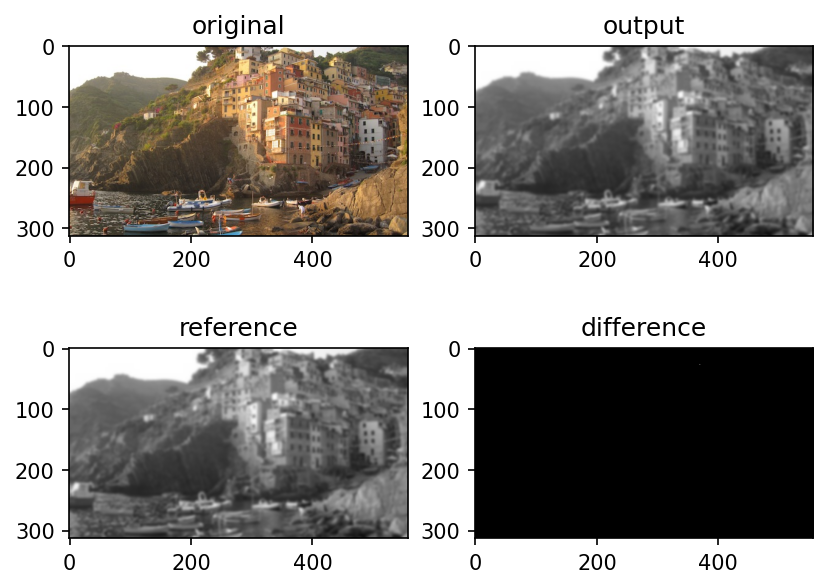

In [38]:
# plot output images
import matplotlib.pyplot as plt
import cv2
_,ax = plt.subplots(2,2, dpi=150)

ax[0][0].imshow(plt.imread("../src/HW1/cinque_terre_small.jpg"))
ax[0][0].set_title("original")
ax[0][0].grid(False)

ax[0][1].imshow(plt.imread("HW2_output.png"), cmap="gray")
ax[0][1].set_title("output")
ax[0][1].grid(False)

ax[1][0].imshow(plt.imread("HW2_reference.png"), cmap="gray")
ax[1][0].set_title("reference")
ax[1][0].grid(False)

ax[1][1].imshow(plt.imread("HW2_differenceImage.png"), cmap="gray")
ax[1][1].set_title("difference")
ax[1][1].grid(False)

plt.show()